# Design of Experiments

In [1]:
# Import libraries

from doemodels.factorial import Factorial2k #https://github.com/kameelsky/doe-models.git
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from utils import SQL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as smp
from scipy.stats import shapiro, f

In [2]:
def RMSE(y, y_pred) -> float:
    return np.sqrt(np.mean((y - y_pred) ** 2))

def substitute_interactions(interactions: list[str], factors_dictionary: dict[str]) -> list[str]:
    return [(factors_dictionary[interaction[0]], factors_dictionary[interaction[1]]) for interaction in interactions]

def interactions_plots(experiments_DataFrame: pd.DataFrame, target_name:str, interactions_list: list[tuple[str, str]], grid_layout: tuple[int, int]):
    interaction_data = experiments_DataFrame.reset_index()
    grid = grid_layout
    plot_coordinates = [(i, j) for i in range(grid[0]) for j in range(grid[1])]
    dictionary_combinations = {key:value for key, value in zip(plot_coordinates, interactions_list)}
    dictionary_combinations

    _, axes = plt.subplots(figsize=(20, 10), ncols=grid[0], nrows=grid[1])

    for key, value in dictionary_combinations.items():
        ax = axes[key[1], key[0]]
        ax.set_title(" : ".join(list(value)))
        interaction_plot(
            interaction_data[value[0]],
            interaction_data[value[1]],
            interaction_data[target_name],
            colors=['red','blue'], markers=['D','^'], ms=10,
            ax=ax
        )
        ax.set_ylim(interaction_data[target_name].min() * 0.95, interaction_data[target_name].max() * 1.05)

    plt.show()

## Full factorial design: $2^k$

We have different factors (**Temperature**, **Lubrication**, **Material**, **Brand**) and want to find out which of them has the highest impact on the dependent variable (**Friction**). Conducting full factorial design at two levels (low, high) may anwser this question and provide information about all posible interactions which can occur.

In [3]:
# Define independent variables and factors
independent_variables = ["Temperature", "Lubrication", "Material", "Brand"]
factors = ["A", "B", "C", "D"]
factors_dictionary = {key:value for key, value in zip(factors, independent_variables)}

# We create a design, which is an instance of Factorial2k class
design = Factorial2k(columns_input=factors)
original_desing = design.DataFrame.copy()
experiments = design.DataFrame.copy()
original_desing

,A,B,C,D,AB,AC,AD,BC,BD,CD,ABC,ABD,ACD,BCD,ABCD
Experiments,,,,,,,,,,,,,,,
1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1
2,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1
3,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1
4,1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,1
5,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1
6,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,-1,1,1
7,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1
8,1,1,1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1
9,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1


In [4]:
experiments = experiments[["A", "B", "C", "D"]]
experiments.columns = independent_variables

experiments["Temperature"] = experiments["Temperature"].replace({-1: "low", 1: "high"})
experiments["Lubrication"] = experiments["Lubrication"].replace({-1: "oil", 1: "grease"})
experiments["Material"] = experiments["Material"].replace({-1: "steel", 1: "ceramic"})
experiments["Brand"] = experiments["Brand"].replace({-1: "BMW", 1: "Mercedes"})

# After conducting experiments we get a response
experiments["Friction"] = [112, 106, 120, 108, 114, 108, 123, 110, 113, 105, 121, 109, 114, 108, 121, 110]
experiments

,Temperature,Lubrication,Material,Brand,Friction
Experiments,,,,,
1,low,oil,steel,BMW,112
2,high,oil,steel,BMW,106
3,low,grease,steel,BMW,120
4,high,grease,steel,BMW,108
5,low,oil,ceramic,BMW,114
6,high,oil,ceramic,BMW,108
7,low,grease,ceramic,BMW,123
8,high,grease,ceramic,BMW,110
9,low,oil,steel,Mercedes,113


### Effects

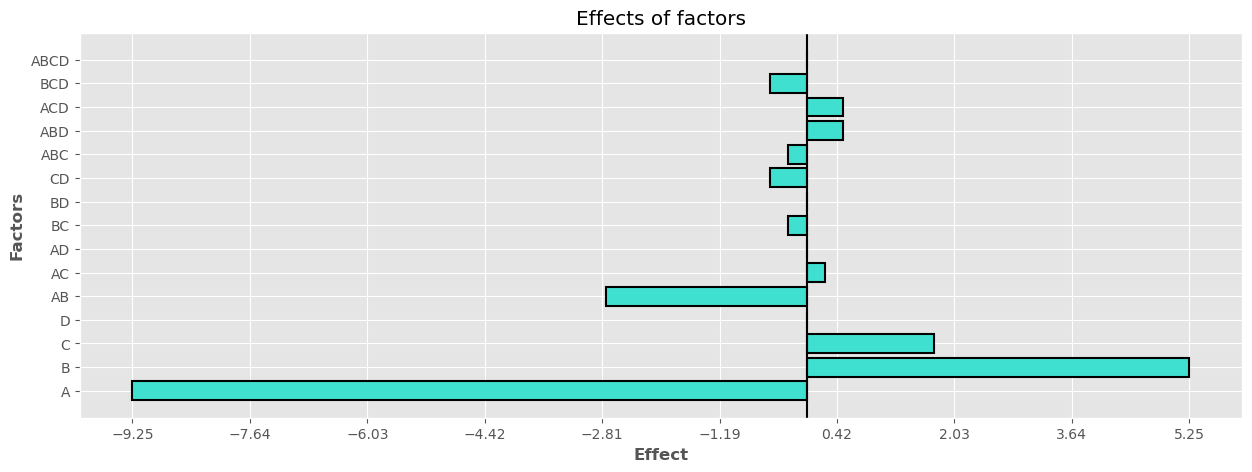

In [5]:
# Plot a graph of effects
design.effects(response=experiments["Friction"], graph=True)

In [6]:
design.effects_table

,A,B,C,D,AB,AC,AD,BC,BD,CD,ABC,ABD,ACD,BCD,ABCD
Response,-9.25,5.25,1.75,0.0,-2.75,0.25,0.0,-0.25,0.0,-0.5,-0.25,0.5,0.5,-0.5,0.0


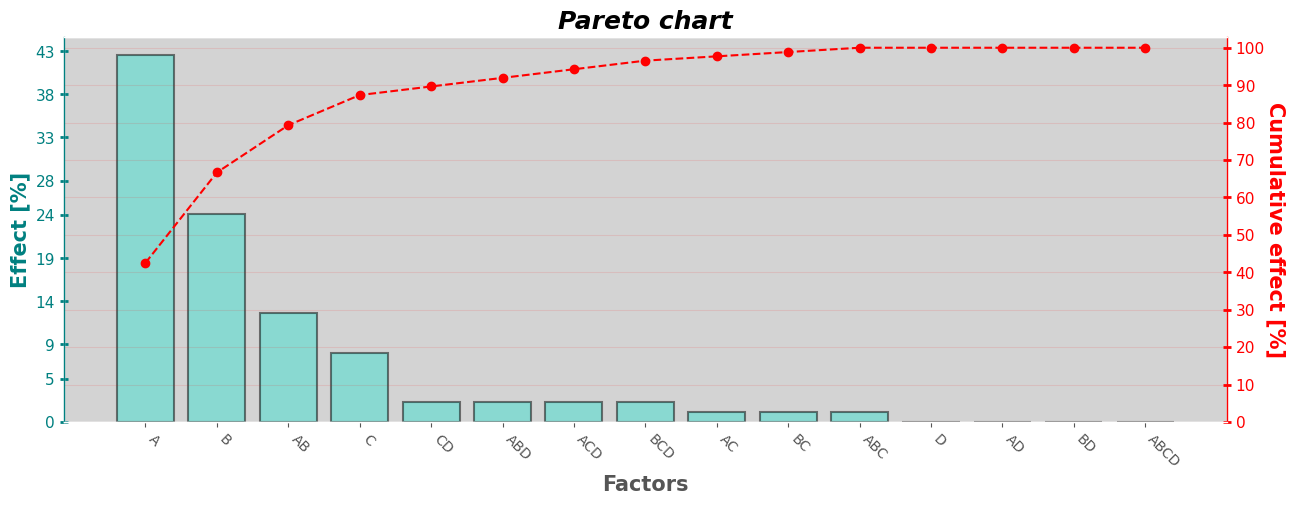

In [7]:
# Pareto chart
design.pareto(graph=True)

In [8]:
print(factors_dictionary)
design.pareto_table

{'A': 'Temperature', 'B': 'Lubrication', 'C': 'Material', 'D': 'Brand'}


,Response,%,cum_sum_%
A,-9.25,42.53,42.53
B,5.25,24.14,66.67
AB,-2.75,12.64,79.31
C,1.75,8.05,87.36
CD,-0.50,2.30,89.66
ABD,0.50,2.30,91.96
ACD,0.50,2.30,94.26
BCD,-0.50,2.30,96.56
AC,0.25,1.15,97.71
BC,-0.25,1.15,98.86


### Second order interactions plotting

In [9]:
second_order_interactions = [i for i in original_desing.columns if len(i) == 2] # e.g. ['AB', 'AC', 'AD', 'BC', 'BD', 'CD']
interactions = substitute_interactions(interactions=second_order_interactions, factors_dictionary=factors_dictionary)
interactions

[('Temperature', 'Lubrication'),
 ('Temperature', 'Material'),
 ('Temperature', 'Brand'),
 ('Lubrication', 'Material'),
 ('Lubrication', 'Brand'),
 ('Material', 'Brand')]

{'A': 'Temperature', 'B': 'Lubrication', 'C': 'Material', 'D': 'Brand'}


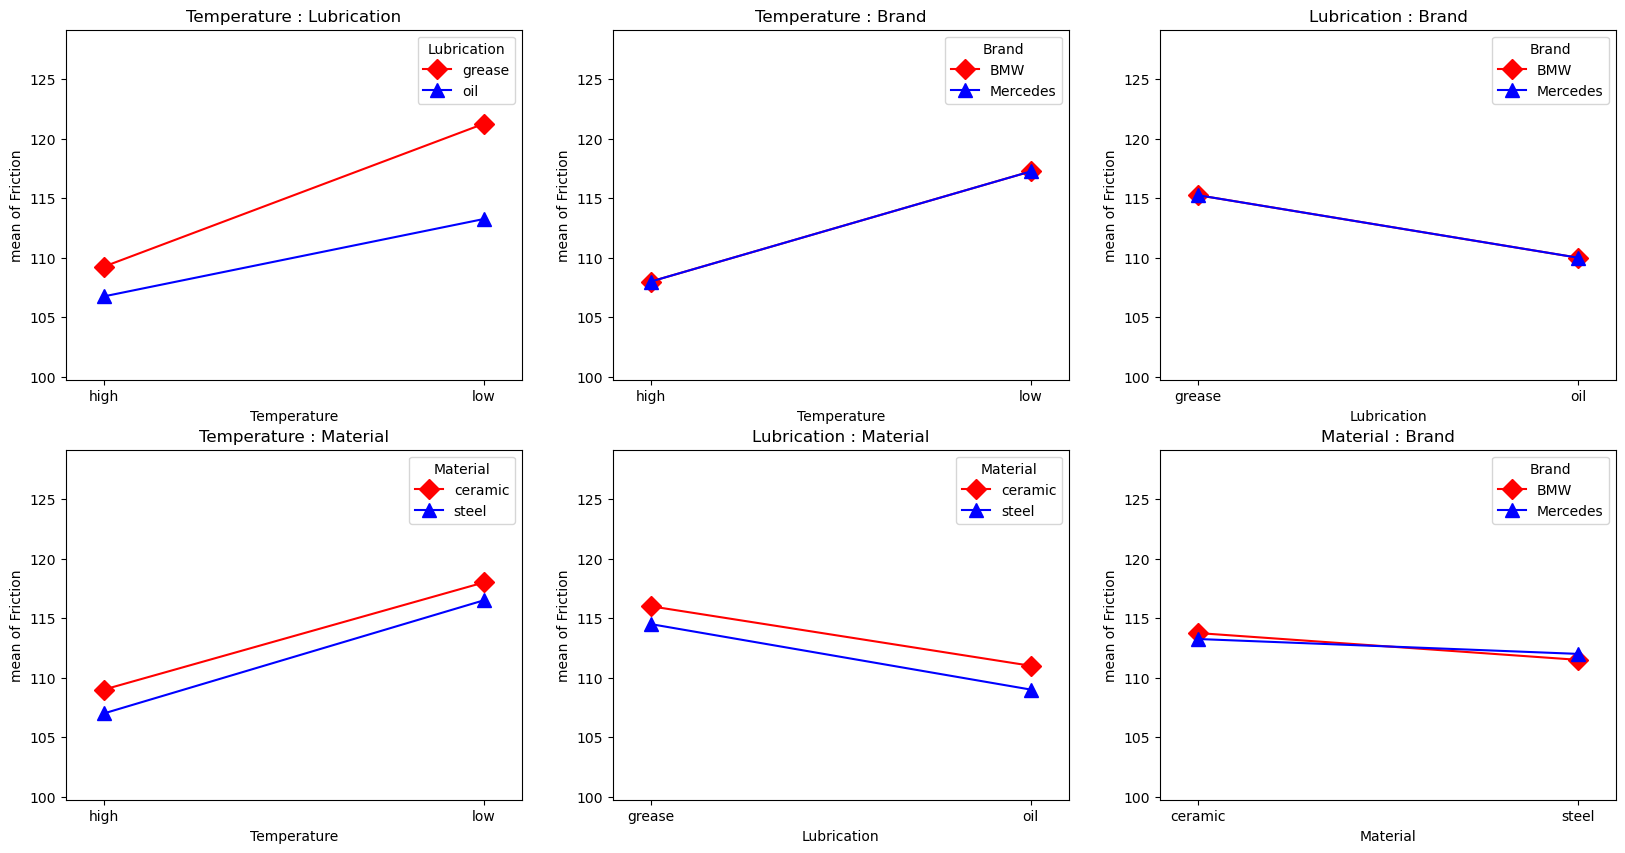

In [10]:
print(factors_dictionary)
interactions_plots(experiments_DataFrame=experiments, target_name="Friction", interactions_list=interactions, grid_layout=(3,2))

### Now we will build a model to predict the friction.

In [11]:
model1 = smf.ols(formula="Friction ~ Temperature*Lubrication", data=experiments).fit()
model2= smf.ols(formula="Friction ~ Temperature*Lubrication + Material", data=experiments).fit()
model3 = smf.ols(formula="Friction ~ Temperature*Lubrication + Material + Brand", data=experiments).fit()

In [12]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               Friction   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     113.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           4.48e-09
Time:                        12:55:33   Log-Likelihood:                -23.188
No. Observations:                  16   AIC:                             54.38
Df Residuals:                      12   BIC:                             57.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/home/kamil/miniconda3/envs/DataScience/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               Friction   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     286.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           4.88e-11
Time:                        12:55:33   Log-Likelihood:                -12.987
No. Observations:                  16   AIC:                             35.97
Df Residuals:                      11   BIC:                             39.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/home/kamil/miniconda3/envs/DataScience/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [14]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               Friction   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     208.4
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           8.99e-10
Time:                        12:55:33   Log-Likelihood:                -12.987
No. Observations:                  16   AIC:                             37.97
Df Residuals:                      10   BIC:                             42.61
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/home/kamil/miniconda3/envs/DataScience/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
anova_lm(model1).round(4)

,df,sum_sq,mean_sq,F,PR(>F)
Temperature,1.0,342.25,342.2500,241.5882,0.0000
Lubrication,1.0,110.25,110.2500,77.8235,0.0000
Temperature:Lubrication,1.0,30.25,30.2500,21.3529,0.0006
Residual,12.0,17.00,1.4167,NaN,NaN


In [16]:
anova_lm(model2).round(4)

,df,sum_sq,mean_sq,F,PR(>F)
Temperature,1.0,342.25,342.2500,792.5789,0.0000
Lubrication,1.0,110.25,110.2500,255.3158,0.0000
Material,1.0,12.25,12.2500,28.3684,0.0002
Temperature:Lubrication,1.0,30.25,30.2500,70.0526,0.0000
Residual,11.0,4.75,0.4318,NaN,NaN


In [17]:
anova_lm(model3).round(4)

,df,sum_sq,mean_sq,F,PR(>F)
Temperature,1.0,342.25,342.250,720.5263,0.0000
Lubrication,1.0,110.25,110.250,232.1053,0.0000
Material,1.0,12.25,12.250,25.7895,0.0005
Brand,1.0,0.00,0.000,0.0000,1.0000
Temperature:Lubrication,1.0,30.25,30.250,63.6842,0.0000
Residual,10.0,4.75,0.475,NaN,NaN


In [18]:
anova_lm(model1, model2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,12.0,17.00,0.0,NaN,NaN,NaN
1,11.0,4.75,1.0,12.25,28.368421,0.000242


In [19]:
anova_lm(model2, model3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,11.0,4.75,0.0,NaN,NaN,NaN
1,10.0,4.75,1.0,-0.0,-0.0,1.0


In [20]:
RMSE(y = experiments["Friction"], y_pred = model2.fittedvalues)

0.5448623679425842

Analysis of Variance (ANOVA) indicated that all three models are significant in explaining the variance in the data. The Bayesian Information Criterion (BIC) was the lowest for **Model 2**, indicating it is the most optimal model among those considered. ANOVA also confirmed that all factors are significant in explaining the variance, and all coefficients are significantly different from zero.

Additionally, an Extra Sum of Squares F test confirmed that **Model 2** better explains the variance compared to Model 1, but we cannot make the same conclusion when comparing **Model 3** to **Model 2**.

$Friction = 110.125 + 12*Temperature_{low} - 2.5 * Lubrication_{oil} - 1.75 * Material_{steel} - 5.5 * Temperature_{low} * Lubrication_{oil}$

In principle we can conclude that to dominish the friction we should have oil and steel as lubrication and material, respectively. Also higher temperature reduces friction.

In [21]:
Thigh = model2.predict({"Temperature": "high", "Lubrication": "oil", "Material": "steel"}).values[0].round(2)
Tlow = model2.predict({"Temperature": "low", "Lubrication": "oil", "Material": "steel"}).values[0].round(2)

print(f"Using steel as a material and oil for lubrication, at high temperatures we expect to reach friction: {Thigh}")
print(f"Using steel as a material and oil for lubrication, at low temperatures we expect to reach friction: {Tlow}")

Using steel as a material and oil for lubrication, at high temperatures we expect to reach friction: 105.88
Using steel as a material and oil for lubrication, at low temperatures we expect to reach friction: 112.38


# Fractional factorial design: $2^{k-n}$

Can we get similiar conclusions, but reduce the number of experiments by half? We can perform fractional factorial design $2^{4-1}_{IV}$. Resolution $IV$ indicates that some of main effects are aliased by $3^{rd}$ order interactions, and $2^{nd}$ order interactions are aliased with other $2^{nd}$ order interactions.

In [22]:
# Define independent variables and factors
independent_variables = ["Temperature", "Lubrication", "Material", "Brand"]
factors = ["A", "B", "C", "D"]

# We create a design, which is an instance of Factorial2k class
design = Factorial2k(columns_input=factors)

# We create design I=ABCD
design.fractional(principal_fraction="ABCD")

In [23]:
# Dictionary of aliases
design.aliases

{'A': ['BCD'],
 'B': ['ACD'],
 'C': ['ABD'],
 'D': ['ABC'],
 'AB': ['CD'],
 'AC': ['BD'],
 'AD': ['BC'],
 'BC': ['AD'],
 'BD': ['AC'],
 'CD': ['AB'],
 'ABC': ['D'],
 'ABD': ['C'],
 'ACD': ['B'],
 'BCD': ['A']}

In [24]:
design.DataFrame_AntiAliased

,A,B,C,D,AB,AC,AD
Experiments,,,,,,,
1,-1,-1,-1,-1,1,1,1
2,1,1,-1,-1,1,-1,-1
3,1,-1,1,-1,-1,1,-1
4,-1,1,1,-1,-1,-1,1
5,1,-1,-1,1,-1,-1,1
6,-1,1,-1,1,-1,1,-1
7,-1,-1,1,1,1,-1,-1
8,1,1,1,1,1,1,1


In [25]:
experiments = design.DataFrame_AntiAliased.copy()
experiments = experiments[["A", "B", "C", "D"]]
experiments.columns = independent_variables

experiments["Temperature"] = experiments["Temperature"].replace({-1: "low", 1: "high"})
experiments["Lubrication"] = experiments["Lubrication"].replace({-1: "oil", 1: "grease"})
experiments["Material"] = experiments["Material"].replace({-1: "steel", 1: "ceramic"})
experiments["Brand"] = experiments["Brand"].replace({-1: "BMW", 1: "Mercedes"})

experiments

,Temperature,Lubrication,Material,Brand
Experiments,,,,
1,low,oil,steel,BMW
2,high,grease,steel,BMW
3,high,oil,ceramic,BMW
4,low,grease,ceramic,BMW
5,high,oil,steel,Mercedes
6,low,grease,steel,Mercedes
7,low,oil,ceramic,Mercedes
8,high,grease,ceramic,Mercedes


In [26]:
experiments["Friction"] = [112, 108, 108, 123, 105, 121, 114, 110]
experiments

,Temperature,Lubrication,Material,Brand,Friction
Experiments,,,,,
1,low,oil,steel,BMW,112
2,high,grease,steel,BMW,108
3,high,oil,ceramic,BMW,108
4,low,grease,ceramic,BMW,123
5,high,oil,steel,Mercedes,105
6,low,grease,steel,Mercedes,121
7,low,oil,ceramic,Mercedes,114
8,high,grease,ceramic,Mercedes,110


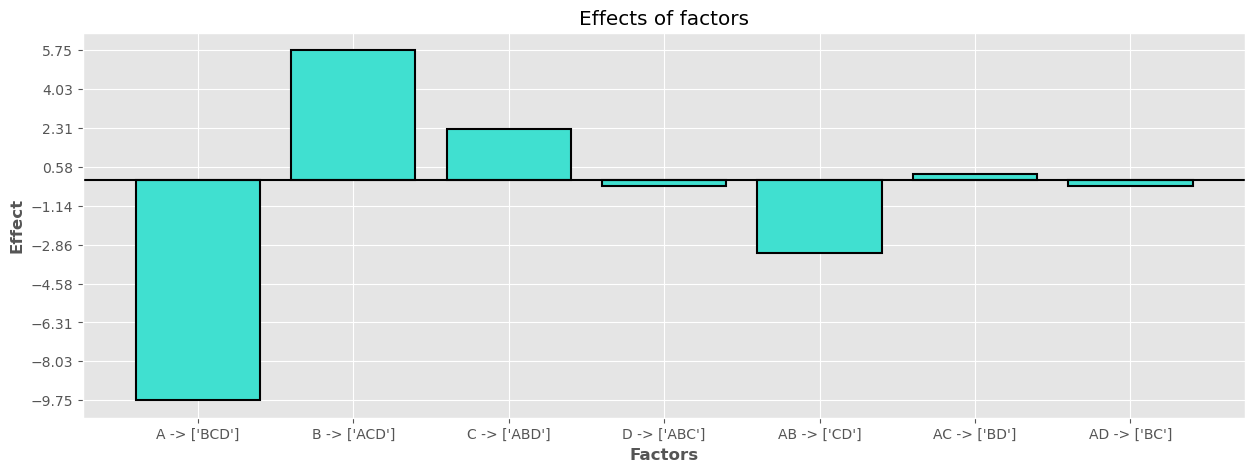

In [27]:
design.effects(response=experiments["Friction"], graph=True)

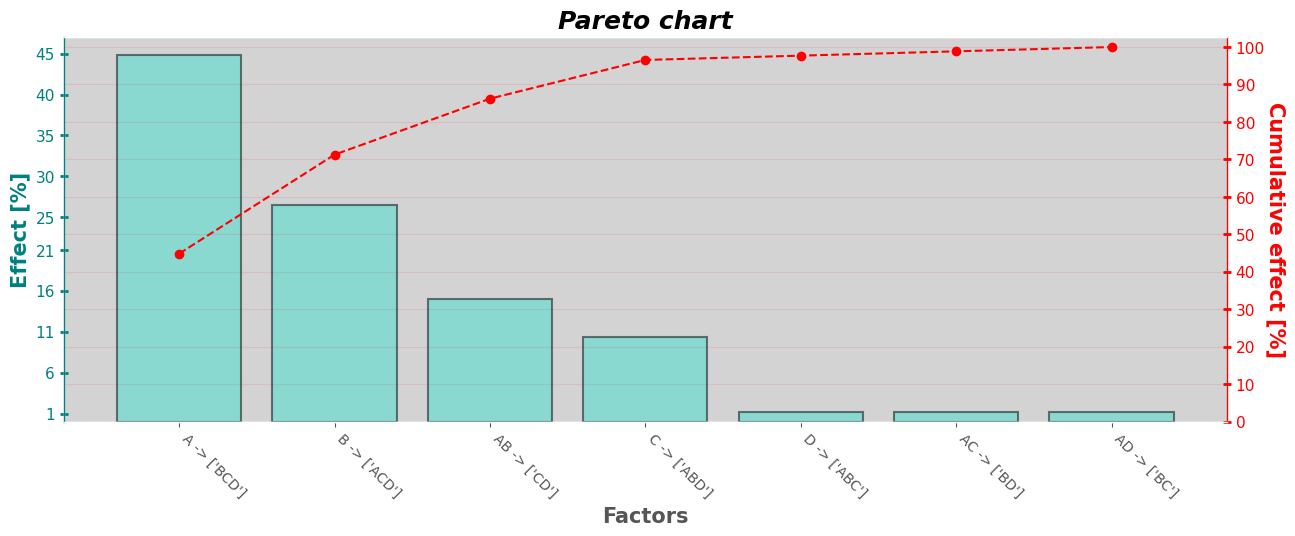

In [28]:
design.pareto(graph=True)

There is no doubt that factor A (Temperature) and B (Lubrication) have high impact on Friction. However Factor AB is aliased with Factor CD. Taking into account that Factor C has less impact on the response we can assume that observed effect derives from interaction of A and B, rather than C and D. 

# Optimization using Central Composite Design

In [29]:
# Import dataset

sql = SQL(database="../database.db")
sql.tabales

['Customers', 'CCD', 'Full-factorial']

In [30]:
df = sql.data_frame("CCD")
df

,Cond,pH,Capacity
0,5.0,5.0,96
1,15.0,5.0,102
2,5.0,7.0,137
3,15.0,7.0,4
4,5.0,6.0,139
5,15.0,6.0,54
6,10.0,5.0,119
7,10.0,7.0,84
8,10.0,6.0,121
9,10.0,6.0,137


In [31]:
df.to_clipboard()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


In optimization designs a second order polynomial model is ubiquitous:

$f(x_1, x_2) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1 x_2 + \beta_{11} x_1^2 + \beta_{22} x_2^2$

### Model building

In [32]:
# Build a model
model = smf.ols(formula="Capacity ~ Cond*pH + I(Cond**2) + I(pH**2)", data=df).fit()

### Assumption of Multicollinearity

In [33]:
df.corr()

,Cond,pH,Capacity
Cond,1.000000e+00,2.960595e-17,-0.656848
pH,2.960595e-17,1.000000e+00,-0.285047
Capacity,-6.568480e-01,-2.850473e-01,1.000000


There is no strong correlation between the independent variables (**pH**, **Cond**), meaning there is no need to worry about multicollinearity.

### Assumption of Independent Errors

In [34]:
sm.stats.durbin_watson(model.resid)

1.8627613125682005

The statistical value ranges between 0-4 where a value closer to 0 is more evidence for positive serial correlation and a value closer to 4 is more evidence for negative serial correlation. Value of 2, or close to it, is ideal.

### Assumption of Normality of the Residuals

In [35]:
shapiro(model.resid)

ShapiroResult(statistic=0.9959913094123662, pvalue=0.9999622807182796)

### Assumption of Homoscedasticity

In [36]:
test_stat, pvalue, _, _ = sm.stats.het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan test p-value: {pvalue.round(3)}")

Breusch-Pagan test p-value: 0.438


## Model validation

In [37]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Capacity   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     38.23
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           0.000548
Time:                        12:55:34   Log-Likelihood:                -35.929
No. Observations:                  11   AIC:                             83.86
Df Residuals:                       5   BIC:                             86.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -904.9649    214.090     -4.227   

/home/kamil/miniconda3/envs/DataScience/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)


In [38]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Cond,1.0,7490.666667,7490.666667,84.636107,0.000255
pH,1.0,1410.666667,1410.666667,15.938946,0.010402
Cond:pH,1.0,4830.250000,4830.250000,54.576391,0.000715
I(Cond ** 2),1.0,2283.103030,2283.103030,25.796496,0.003838
I(pH ** 2),1.0,904.428070,904.428070,10.219020,0.024083
Residual,5.0,442.521930,88.504386,NaN,NaN


- All factors are significant in reducing variance of the data.
- All coefficients in the model are significantly different than 0.

In [39]:
df['predicted'] = model.fittedvalues

grouped = df.groupby(['Cond', 'pH'])
df['mean_response'] = grouped['Capacity'].transform('mean')
df['pure_error_sq'] = (df['Capacity'] - df['mean_response'])**2 

# Pure Error
pure_error = df['pure_error_sq'].sum()

# Lack of Fit Error
df['lack_of_fit_sq'] = (df['mean_response'] - df['predicted'])**2
lack_of_fit_error = df['lack_of_fit_sq'].sum()

# Residual Error
residual_error = pure_error + lack_of_fit_error

# Degrees of freedom
df_lof = len(grouped) - (model.df_model + 1)
df_pe = df.shape[0] - len(grouped)

# F-Test for Lack of Fit
F_stat = (lack_of_fit_error / df_lof) / (pure_error / df_pe)
p_value = f.sf(F_stat, df_lof, df_pe)

print(f"Pure Error: {pure_error}")
print(f"Lack of Fit Error: {lack_of_fit_error}")
print(f"F-statistic: {F_stat}")
print(f"P-value: {p_value}")

Pure Error: 130.66666666666666
Lack of Fit Error: 311.8552631578936
F-statistic: 1.5910982814178247
P-value: 0.4084010146010963


## Model visualization

In [40]:
b0, b1, b2, b12, b11, b22, x1, x2 = smp.symbols("beta_0, beta_1, beta_2, beta_12, beta_11, beta_22, x_1, x_2", real=True) # Variables and coefficients
formula = b0 + b1*x1 + b2*x2 + b12*x1*x2 + b11*x1**2 + b22*x2**2
formula # Sympy formula

beta_0 + beta_1*x_1 + beta_11*x_1**2 + beta_12*x_1*x_2 + beta_2*x_2 + beta_22*x_2**2

In [41]:
coeffs = [i for i in zip([b0, b1, b2, b12, b11, b22], model.params.values)]
coeffs # List of coefficients tuples

[(beta_0, -904.9649122806939),
 (beta_1, 53.749122807017635),
 (beta_2, 280.90350877192924),
 (beta_12, -6.950000000000063),
 (beta_11, -0.9557894736842054),
 (beta_22, -18.89473684210529)]

In [42]:
formula_subs = formula.subs(coeffs)
formula_subs # Sympy formula with coefficients substituted

-0.955789473684205*x_1**2 - 6.95000000000006*x_1*x_2 + 53.7491228070176*x_1 - 18.8947368421053*x_2**2 + 280.903508771929*x_2 - 904.964912280694

In [43]:
f = smp.lambdify((x1, x2), formula_subs) # Function originating from Sympy formula, which takes two arguments
cond_domain = np.linspace(df["Cond"].min(), df["Cond"].max(), 100)
ph_domain = np.linspace(df["pH"].min(), df["pH"].max(), 100)

cond_domain_mesh, ph_domain_mesh = np.meshgrid(cond_domain, ph_domain) # Meshgrid of pH and Cond domains
capacity_mesh = f(cond_domain_mesh, ph_domain_mesh) # Meshgrid of response variable

### 3-dimensional model

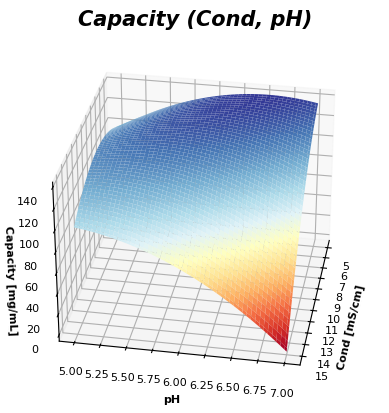

In [44]:
ax = plt.axes(projection="3d")
ax.plot_surface(cond_domain_mesh, ph_domain_mesh, capacity_mesh, cmap="RdYlBu")

# Ticks
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(5, 16, 1))
ax.set_yticks(np.arange(5, 7.25, 0.25))

# Labels
ax.set_title("Capacity (Cond, pH)", fontsize=15, fontweight="bold", fontstyle="italic", ha="center")
ax.set_xlabel("Cond [mS/cm]", fontsize=8, fontweight="bold", labelpad=1)
ax.set_ylabel("pH", fontsize=8, fontweight="bold", labelpad=1)
ax.set_zlabel("Capacity [mg/mL]", fontsize=8, fontweight="bold", labelpad=-0.4)

ax.grid(True)

ax.view_init(elev=30, azim=10)

plt.show()

### Isomesh plot

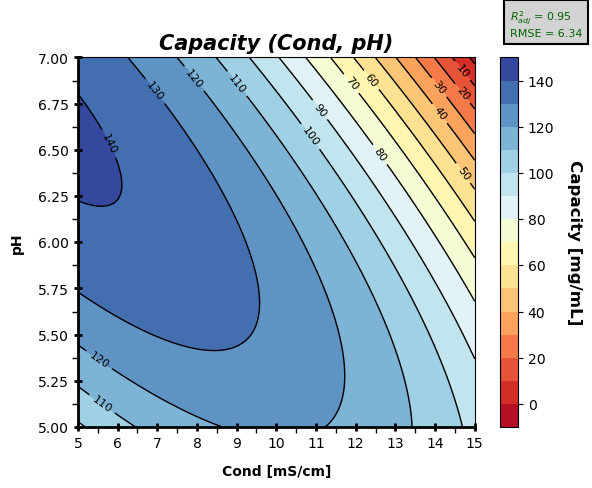

In [45]:
fig, ax = plt.subplots(dpi=100)

cf = ax.contourf(cond_domain_mesh, ph_domain_mesh, capacity_mesh, cmap="RdYlBu", levels=16)
cp = ax.contour(cond_domain_mesh, ph_domain_mesh, capacity_mesh, colors="black", levels=16, linewidths=1)
cbar = plt.colorbar(cf) # Add colorbar
plt.clabel(cp, fontsize=8) # Add labels of contours

# Spines
ax = plt.gca()
for i in ["left", "bottom"]:
    ax.spines[i].set_linewidth(2)

# Ticks
ax.minorticks_on()
ax.tick_params(which='minor', width=1, length=4, direction="out")
ax.tick_params(which='major', width=2, length=6, direction="inout", labelsize=10)
ax.set_xticks(np.arange(5, 16, 1))
ax.set_xticks(np.arange(5, 15, 1/2), minor=True)
ax.set_yticks(np.arange(5, 7.25, 0.25))
ax.set_yticks(np.arange(5, 7, 0.25/2), minor=True)

# Labels
ax.set_title("Capacity (Cond, pH)", fontsize=15, fontweight="bold", fontstyle="italic", ha="center")
ax.set_xlabel("Cond [mS/cm]", fontsize=10, fontweight="bold", labelpad=10)
ax.set_ylabel("pH", fontsize=10, fontweight="bold", labelpad=10)
cbar.set_label('Capacity [mg/mL]', rotation=-90, labelpad=20, fontsize=12, fontweight='bold')

# Text
ax.text(x=0.8, y=0.95, transform=fig.transFigure,
        s=r"$R^2_{adj}$" + f" = {model.rsquared_adj:.2f}" + f"\nRMSE = {RMSE(y = df['Capacity'], y_pred=df['predicted']):.2f}", color="darkgreen",
        bbox=dict(facecolor="lightgrey", linewidth=1.5, edgecolor="black"), va="center", ha="left", fontsize=8)

plt.show()

### Isomesh plot and gradient of the function

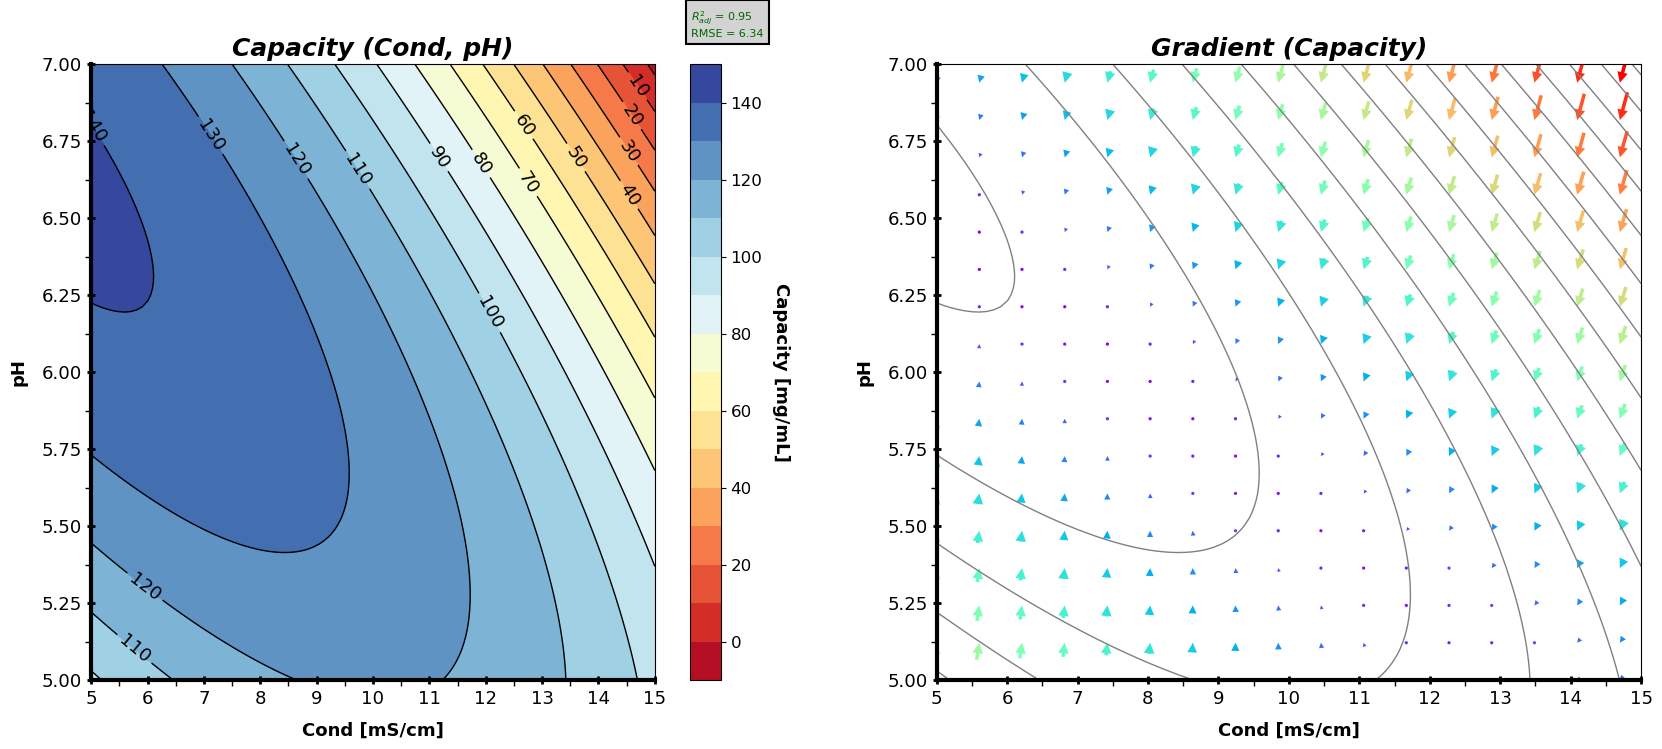

In [46]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))

# First plot (Capacity)
ax = axes[0]
cf = ax.contourf(cond_domain_mesh, ph_domain_mesh, capacity_mesh, cmap="RdYlBu", levels=16)
cp = ax.contour(cond_domain_mesh, ph_domain_mesh, capacity_mesh, colors="black", levels=16, linewidths=1)
cbar = plt.colorbar(cf)
cbar.ax.tick_params(labelsize=12)
plt.clabel(cp, fontsize=13)

ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

# Ticks and Labels
ax.minorticks_on()
ax.tick_params(which='minor', width=1, length=4, direction="out")
ax.tick_params(which='major', width=2, length=6, direction="inout", labelsize=13)
ax.set_xticks(np.arange(5, 16, 1))
ax.set_xticks(np.arange(5, 15, 1/2), minor=True)
ax.set_yticks(np.arange(5, 7.25, 0.25))
ax.set_yticks(np.arange(5, 7, 0.25/2), minor=True)

ax.set_title("Capacity (Cond, pH)", fontsize=18, fontweight="bold", fontstyle="italic", ha="center")
ax.set_xlabel("Cond [mS/cm]", fontsize=13, fontweight="bold", labelpad=10)
ax.set_ylabel("pH", fontsize=13, fontweight="bold", labelpad=10)
cbar.set_label('Capacity [mg/mL]', rotation=-90, labelpad=20, fontsize=13, fontweight='bold')

ax.text(x=0.425, y=0.93, transform=fig.transFigure,
        s=r"$R^2_{adj}$" + f" = {model.rsquared_adj:.2f}" + f"\nRMSE = {RMSE(y = df['Capacity'], y_pred=df['predicted']):.2f}", 
        color="darkgreen", bbox=dict(facecolor="lightgrey", linewidth=1.5, edgecolor="black"), va="center", ha="left", fontsize=8)

# Gradient
ax = axes[1]
dy, dx = np.gradient(capacity_mesh, ph_domain, cond_domain)

# Magnitude of gradient
M = np.hypot(dy, dx)

def gradient_plot(spacing: int, scale: float):
    ax.quiver(cond_domain_mesh[::spacing, ::spacing], ph_domain_mesh[::spacing, ::spacing], dx[::spacing, ::spacing], dy[::spacing, ::spacing], 
              M[::spacing, ::spacing], pivot='tip', units="x", scale=scale, cmap="rainbow", width=0.05, headwidth=3, headlength=3, headaxislength=3)

# Adjusting the spacing and scaling for the quiver plot
gradient_plot(spacing=6, scale=200)

cp = ax.contour(cond_domain_mesh, ph_domain_mesh, capacity_mesh, colors="grey", levels=16, linewidths=1)

ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

ax.minorticks_on()
ax.tick_params(which='minor', width=1, length=4, direction="out")
ax.tick_params(which='major', width=2, length=6, direction="inout", labelsize=13)
ax.set_xticks(np.arange(5, 16, 1))
ax.set_xticks(np.arange(5, 15, 1/2), minor=True)
ax.set_yticks(np.arange(5, 7.25, 0.25))
ax.set_yticks(np.arange(5, 7, 0.25/2), minor=True)

ax.set_title("Gradient (Capacity)", fontsize=18, fontweight="bold", fontstyle="italic", ha="center")
ax.set_xlabel("Cond [mS/cm]", fontsize=13, fontweight="bold", labelpad=10)
ax.set_ylabel("pH", fontsize=13, fontweight="bold", labelpad=10)

plt.show()

## Calculating critical points


Magnitude of gradient vector $\left|\vec{R}\right|$ equals 0 at $x_1$ and $x_2$ coordinates for which function $f(x_1, x_2)$ returns critical points. Therefore, to find $x_1$ and $x_2$ values which return gradient vector $\left[\begin{matrix} 0\hat i \\ 0\hat j \end{matrix} \right]$, partial derivatives has to be solved for respective scalars of $\hat{i}$ and $\hat{j}$ vectors:

$\vec{R} = \nabla f(x_{1}, x_{2})
= \left[\begin{matrix} \frac{\partial f(x_1, x_2)}{\partial x_1} \hat i \\ \frac{\partial f(x_1, x_2)}{\partial x_2} \hat j \end{matrix} \right]
= \vec{0}$

Taking derivatives from the model equation is not complicated and we can do it manually:

- At first, let's take partial **derivative in respect to $x_1$**:

$
\frac{\partial f}{\partial x_1} (x_1, x_2) =  
\frac{\partial \beta_1 x_1}{\partial x_1} + 
\frac{\partial \beta_2 x_2}{\partial x_1} +
\frac{\partial \beta_{12} x_1 x_2}{\partial x_1} +
\frac{\partial \beta_{11} x_1^2}{\partial x_1} +
\frac{\partial \beta_{22} x_2^2}{\partial x_1}
$

$
=\beta_1\frac{\partial x_1}{\partial x_1} + 
\beta_2\frac{\partial x_2}{\partial x_1} +
\beta_{12} x_2\frac{\partial x_1}{\partial x_1} +
\beta_{11}\frac{\partial x_1^2}{\partial x_1} +
\beta_{22}\frac{\partial x_2^2}{\partial x_1}
$

$
=(\beta_1 * 1) + 
(\beta_2 * 0) +
(\beta_{12} x_2 * 1) +
(\beta_{11} * 2 * x_1) +
(\beta_{22} * 0)
$

$
=\beta_1 + \beta_{12} x_2 + 2\beta_{11}x_1
$

- Similarly, **derivative in respect to $x_2$ equals**:

$\frac{\partial f}{\partial x_2} (x_1, x_2) = \beta_2 + \beta_{12} x_1 + 2\beta_{22}x_2$

or use ***SymPy package***, which makes it even easier:

In [47]:
dydx1 = smp.diff(formula, x1) # partial derivative in respect to Cond
dydx2 = smp.diff(formula, x2) # partial derivative in respect to pH

In [48]:
dydx1

beta_1 + 2*beta_11*x_1 + beta_12*x_2

In [49]:
dydx2

beta_12*x_1 + beta_2 + 2*beta_22*x_2

Now to simplify calculations we will represent linear equations in matrix form. For this reason we will use SymPy again.
It will create two matrices **$A$** and **$B$**. Their relation can be represented by the following formula:

$AX=B$

where $X$ ia a variables matrix.

In [50]:
Condmax, pHmax = smp.symbols("Cond_max, pH_max")
X = (x1, x2)
A, B = smp.linear_eq_to_matrix([dydx1, dydx2], X)

In [51]:
A

Matrix([
[2*beta_11,   beta_12],
[  beta_12, 2*beta_22]])

In [52]:
B

Matrix([
[-beta_1],
[-beta_2]])

To calculate $X$ variables matrix:

$AX=B$

$A^{-1}AX=A^{-1}B$

$IX=A^{-1}B$

$X=A^{-1}B$

---

### Maximization

To find $x_1$ and $x_2$ values that maximizes function $f(x_1, x_2)$:

$
\underset{x_1, x_2}{\operatorname{argmax}} f(x_1, x_2) =
\left[ \begin{matrix}
2\beta_{11} & \beta_{12} \\
\beta_{12} & 2\beta_{22}
\end{matrix} \right]^{-1}
\left[ \begin{matrix}
-\beta_1 \\
-\beta_2
\end{matrix} \right]
$

---

***Using SymPy:***

In [53]:
eq = smp.Eq(smp.Matrix([Condmax, pHmax]), A.inv() @ B)
eq

Eq(Matrix([
[Cond_max],
[  pH_max]]), Matrix([
[-2*beta_1*beta_22/(4*beta_11*beta_22 - beta_12**2) + beta_12*beta_2/(4*beta_11*beta_22 - beta_12**2)],
[ beta_1*beta_12/(4*beta_11*beta_22 - beta_12**2) - 2*beta_11*beta_2/(4*beta_11*beta_22 - beta_12**2)]]))

We will substitute coefficients with the ones after optimization:

In [54]:
eq = eq.subs(coeffs)
output = eq.rhs
eq

Eq(Matrix([
[Cond_max],
[  pH_max]]), Matrix([
[3.29523586875021],
[6.82734090556849]]))

We can also use sympy.linsolve() function:

In [55]:
smp.linsolve((A.subs(coeffs), B.subs(coeffs)))

{(3.2952358687502, 6.8273409055685)}

or sympy.solve() (**the easiest option**) function:

In [56]:
smp.solve([dydx1.subs(coeffs), dydx2.subs(coeffs)], x1, x2)

{x_1: 3.29523586875016, x_2: 6.82734090556851}

However with matrix option we can calculate the direction of change for every point in the graph:

In [57]:
def gradient(x: float, y: float):
    vector = (A @ smp.Matrix([x, y]) - B).subs(coeffs)
    vector = np.array(vector, dtype=float)
    mag = np.linalg.norm(vector)
    return vector, mag

vector = gradient(15, 7)
vector

(array([[-23.5745614 ],
        [-87.87280702]]),
 90.98016354409711)

Coefficient matrix $A$, take form of Hessian matrix, and by calculating its eigenvalues we will classify the critical point:

In [58]:
eigenvalues = [i for i in A.subs(coeffs).eigenvals().keys()]
print(f"Coefficient matrix eigenvalues: {eigenvalues}")
if eigenvalues[0] < 0 and eigenvalues[1] < 0:
    print("Calculated point is a local maximum.")
elif eigenvalues[0] > 0 and eigenvalues[1] > 0:
    print("Calculated point is a local minimum.")
elif (eigenvalues[0] > 0 and eigenvalues[1] < 0) or (eigenvalues[0] < 0 and eigenvalues[1] > 0):
    print("Calculated point is a saddle.")
else:
    print("Not evaluated.")

Coefficient matrix eigenvalues: [-0.612326486102139, -39.0887261454768]
Calculated point is a local maximum.


Finally, we can calculate the value of capacity using calculated values of pH and conductivity:

In [59]:
critical_value = f(output[0], output[1])
critical_value

142.505114391232

In [60]:
print(f"For conductivity {output[0]:.2f} mS/cm at pH {output[1]:.2f} capacity equals {critical_value:.2f} mg/mL.")

For conductivity 3.30 mS/cm at pH 6.83 capacity equals 142.51 mg/mL.


From a biochemical point of view, loading protein at such a low conductivity is not wise. Protein may precipitate due to electrostatic interactions that are not compensated by a sufficient ionic strength of the solution. Moreover we have gone beyond the predictive scope of the model. Therefore we will focus on fixed level of conductivity: 5 mS/cm

Since pH quadratic term was significantly different from 0, we can caluclate the value of pH, which results with highest capacity at fixed conductivity, using derivatives.

---

Let's have a look how our model changes, when we substitute $x_1$ with 5:

$f(x_1, x_2) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1 x_2 + \beta_{11} x_1^2 + \beta_{22} x_2^2$

$f(x_1=5, x_2) = \beta_0 + 5\beta_1 + \beta_2 x_2 + 5\beta_{12}x_2 + 25\beta_{11} + \beta_{22} x_2^2$

- Sum of $\beta_0$, $5\beta_1$ and $25\beta_{11}$ can be denoted as a new constant variable: $\beta_a$, 
- Sum of $5\beta_{12}x_2$ and $\beta_2x_2$ terms can be denoted as a new term: $\beta_bx_2$

therefore our model can be rewriten as follows:

$f(x_2) = \beta_a +\beta_bx_2 + \beta_{22}x_2^2$

which is a simple quadratic equation.

---

### Maximization

$x_{2, max} = \underset{x_2}{\operatorname{argmax}} f(x_2)$

---

$\frac{df}{dx_2}(x_2) = \frac{d\beta_a}{dx_2} + $
$\frac{d\beta_bx_2}{dx_2} + $
$\frac{d\beta_{22}x_2^2}{dx_2}$

$=\frac{d\beta_a}{dx_2} + $
$\frac{d\beta_bx_2}{dx_2} + $
$\frac{d\beta_{22}x_2^2}{dx_2}$

$= 0 + $
$\beta_b\frac{dx_2}{dx_2} + $
$\beta_{22}\frac{dx_2^2}{dx_2}$

$=(\beta_b\ * 1) + $
$(\beta_{22} * 2 * x_2)$

$=\beta_b + 2\beta_{22}x_2$

$x_{2,max} = \beta_b + 2\beta_{22}x_2 = 0$

or use ***SymPy package***, which again, makes it even easier:

In [61]:
formula_subs.subs(x1, 5) # Model with fixed Cond value

-18.8947368421053*x_2**2 + 246.153508771929*x_2 - 660.114035087711

In [62]:
dydx = smp.diff(formula_subs.subs(x1, 5), x2) # Derivative of the model with Cond fixed at 5
dydx_f = smp.lambdify(x2, dydx) # Derivative function
dydx

246.153508771929 - 37.7894736842106*x_2

In [63]:
smp.diff(formula_subs.subs(x1, 5), x2, 2) # Negative second order derivative indicates that calculated critical point is a local maximum.

-37.7894736842106

In [64]:
ph_solve = smp.solve(dydx, x2) # Solve of derivative function; pH at which model returns maximal value
ph_solve

[6.51381151346330]

In [65]:
critical_value = f(5, ph_solve[0])
critical_value

141.584744671276

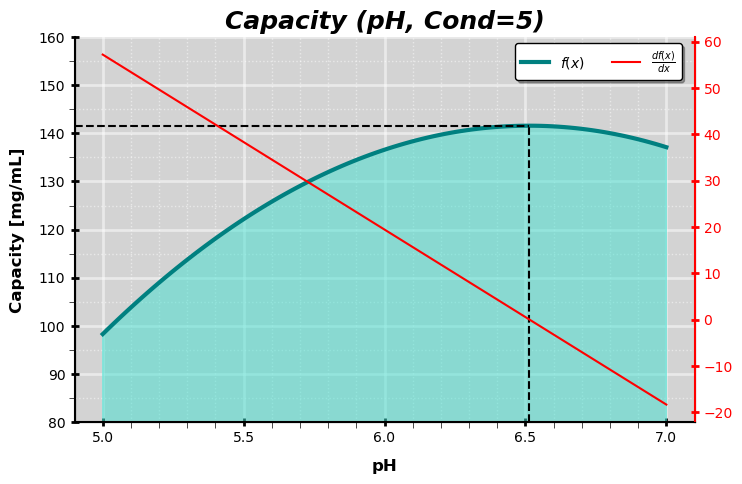

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(ph_domain, f(x_1=5, x_2=ph_domain), label=r"$f(x)$", linewidth=3, color="teal")
ax.fill_between(ph_domain, f(x_1=5, x_2=ph_domain), color="turquoise", alpha=0.5)

# Spines
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["top"].set_visible(False)

# Ticks
ax.minorticks_on()
ax.set_yticks(np.arange(80, 170, 10))
ax.set_yticks(np.arange(80, 160, 10/2), minor=True)
ax.set_xticks(np.arange(5, 7.5, 0.5))
ax.set_xticks(np.arange(5, 7, 0.1), minor=True)
ax.tick_params(which='minor', width=0.5, length=4)
ax.tick_params(which='major', width=2, length=6, direction="inout", labelsize=10)

ax.set_ylim(80, 160)
ax.set_xlim(4.9, 7.1)

# Labels
ax.set_title("Capacity (pH, Cond=5)", fontsize=18, fontweight="bold", fontstyle="italic")
ax.set_ylabel("Capacity [mg/mL]", fontsize=12, fontweight="bold", labelpad=10)
ax.set_xlabel("pH", fontsize=12, fontweight="bold", labelpad=10)

# Grid
ax.set_facecolor("lightgray")
ax.grid(True, which='major', linewidth=2, linestyle='-', alpha=0.5, color="white")
ax.grid(True, which='minor', linewidth=1, linestyle=':', alpha=0.5, color="white")
ax.set_axisbelow(True)

ax2 = plt.twinx()
ax2.plot(ph_domain, dydx_f(x_2=ph_domain), label=r"$\frac{df(x)}{dx}$", linewidth=1.5, color="red")

ax2.spines["right"].set_color("red")
ax2.spines["right"].set_linewidth(1.5)
ax2.spines["top"].set_visible(False)
ax2.tick_params(width=2, length=6, direction="inout", labelsize=10, color="red", labelcolor="red")

# Lines
ax.plot([ph_solve[0], ph_solve[0]], [80, critical_value], color="black", linestyle="--")
ax.plot([4.9, ph_solve[0]], [critical_value, critical_value], color="black", linestyle="--")

fig.legend(fancybox=True, shadow=True, facecolor="white", edgecolor="black", loc='lower center', bbox_to_anchor=(0.78, 0.78), ncol=2)
plt.show()